In [1]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import collections  as mc
import seaborn as sns
style.use('ggplot')

# Geometry Generation Functions

In [2]:
### Multi-Index Functions

def miFactorial(alpha):
    return factorial(alpha).prod()


def miBinomial(alpha, beta):
    return (miFactorial(alpha) 
            /(miFactorial(beta)*miFactorial(alpha - beta)))

In [3]:
### Compute Derivatives of Normal ###
def partialL(P, points):
    # Initialize Quantities
    partial_l = np.zeros(len(points))
    for dim in range(1, D + 1):
        e = np.zeros(D)
        e[dim - 1] = 1
        Q = (P - e).astype(int)
        for r1 in range(Q[0] + 1):
            for r2 in range(Q[1] + 1):
                ### Loop Structure Hard Coded for D = 2
                R = np.array([r1, r2])
                binom = miBinomial(Q, R)
                partial_l += binom*partialN(R, dim, points)*partialPsi(points, Q - R + 2*e)
    return partial_l
 
    
def partialN(P, d, points):
    ## Base Case
    if np.array_equal(P, np.array([0, 0])):
        return (normal(points))[:, d - 1]
    e = np.zeros(D)
    e[d - 1] = 1
    deriv_sums = np.zeros(len(points))
    for q1 in range(P[0] + 1):
        for q2 in range(P[1] + 1):
            ### Loop Structure Hard Coded for D=2 
            Q = np.array([q1, q2])
            if np.array_equal(Q, P):
                continue
            binom = miBinomial(P, Q)
            deriv_sums += binom*partialL(P - Q, points)*partialN(Q, d, points)
    partial_n = partialPsi(points, P + e) - deriv_sums
    return partial_n/L(points)               

# Problem Set Up

The boundary equation is the zero level set of $\psi(\mathbf{x})$
$$ \psi( \mathbf{x} ) = x_1^2 + x_2^2 - 1 $$

In [4]:
### Global Variables ###
D = 2


### HARD CODED FOR PSI(X) = X^2 + Y^2 - 1 ###########
def partialPsi(x, order):
    if np.array_equal(order, np.array([0, 0])):
        return x[:, 0]**2 + x[1]**2 - 1
    elif np.array_equal(order, np.array([1, 0])) or np.array_equal(order, np.array([0, 1])):
        return 2*(order[0]*x[:, 0] + order[1]*x[:, 1])
    elif np.array_equal(order, np.array([2, 0])) or np.array_equal(order, np.array([0, 2])):
        return 2
    else:
        return 0


def L(x):
    return 2*np.sqrt(x[:, 0]**2 + x[:, 1]**2)
#################################################### 


def normal(x):
    dx = partialPsi(x, np.array([1, 0]))
    dy = partialPsi(x, np.array([0, 1]))
    return (np.array([dx, dy])/(np.sqrt(dx**2 + dy**2))).T

In [5]:
# Set Up Function
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x,y)
F = X**2 + Y**2 - 1

# Calculate Normals
level_zero = np.column_stack((X[np.abs(F) <= .001], Y[np.abs(F) <= .001]))
partialPsi(level_zero, np.array([1, 0]))
normals = normal(level_zero)
ends = normals + level_zero
list_zero = list(zip(level_zero[:, 0], level_zero[:, 1]))
list_ends = list(zip(ends[:, 0], ends[:, 1]))
points = [[list_zero[i], list_ends[i]] for i in range(len(level_zero))]

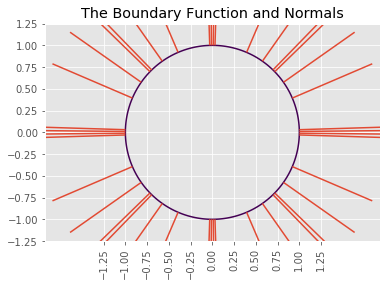

In [6]:
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x,y)
F = X**2 + Y**2 - 1
fig, ax = plt.subplots()
plt.contour(X,Y,F,[0])
plt.grid(True)
plt.xticks(np.linspace(-1.25, 1.25, 11), rotation='vertical')
plt.yticks(np.linspace(-1.25, 1.25, 11))
plt.axis('equal')
plt.axis((-1.25,1.25,-1.25,1.25))
plt.title("The Boundary Function and Normals")

# Plot Normals
line_segments = mc.LineCollection(points)
ax.add_collection(line_segments)
plt.show()

In [26]:
# Cell Centers
h = .25
a = -1.25
b = 1.25
x = np.linspace(a, b, int((b-a)/h))
y = np.linspace(a, b, int((b-a)/h))
X, Y = np.meshgrid(x,y)
points = np.array(list(zip(X.flatten(), Y.flatten())))
num_cells = len(points)

In [27]:
# Global Variables
Q = 4

#### 0. Compute Derivatives of the Normal

In [22]:
normals = np.zeros([Q+1, Q+1, num_cells, 2])
for q_mag in range(Q, -1, -1):
    for q1 in range(q_mag+1):
        q = np.array([q1, q_mag - q1])
        normals[q1, q_mag - q1, :, 0] = partialN(q, 1, points)
        normals[q1, q_mag - q1, :, 1] = partialN(q, 2, points)

##### 1. Compute One-Dimensional Moments $M_{V, 1}^q$

In [44]:
vol_frac_1d = np.zeros([num_cells, 4])
# Iterate Through Cells
for cell in range(num_cells):
    # Center point
    center = points[cell]
    # Find values at corners
    ll = center + np.array([-h/2, -h/2])
    ul = center + np.array([-h/2, h/2])
    ur = center + np.array([h/2, h/2])
    lr = center + np.array([h/2, -h/2])
    corners = np.array([ll, ul, ur, lr])
    # Determine If Cell is Inside/Outside/Boundary
    # Note: This ignores a lot of edge/corner cases. Need to Revisit. 
    if (corners[:, 0]**2 + corners[:, 1]**2 <= 1).all(): # cell entirely in boundary
        vol_frac_1d[cell, :] = 1
    elif (corners[:, 0]**2 + corners[:, 1]**2 >= 1).all(): # cell entirely outside boundary
        pass
    else: # boundary intersects cell
        # If Boundary Determine which edges intersect Boundary
        inside = (corners[:, 0]**2 + corners[:, 1]**2 <= 1)
        for i in range(4):
            if inside[i] == inside[(i+1)%4]: # no change from corner to corner
                vol_frac_1d[cell, i] = int(inside[i])
            else: # change indicating boundary passes through
                # is this edge vertical or horizontal?
                if (corners[i] - corners[(i+1)%4])[0] == 0: # horizontal
                    # find the intersection of x=corners[i, 0] and x**2 + y**2 - 1
                    y = np.sqrt(1 - corners[i, 0]**2)
                    if corners[i, 1] < 0:
                        y = -y
                    frac = np.abs(y - corners[i, 1])/np.abs(corners[(i+1)%4, 1] - corners[i, 1])
                    if inside[i]:
                        vol_frac_1d[cell, i] = frac
                    else:
                        vol_frac_1d[cell, i] = 1 - frac
                else: # vertical
                    # find the intersection of y=corners[i, 1] and x**2 + y**2 - 1
                    x = np.sqrt(1 - corners[i, 1]**2)
                    if corners[i, 0] < 0:
                        x = -x
                    frac = np.abs(x - corners[i, 0])/np.abs(corners[(i+1)%4, 0] - corners[i, 0])
                    if inside[i]:
                        vol_frac_1d[cell, i] = frac
                    else:
                        vol_frac_1d[cell, i] = 1 - frac

#### 2. Irregular One-Dimensional Moments $M_{B, 1}^q$ Are 0 

#### 3. Main Loop

In [54]:

for q_mag in range(Q, -1, -1):
    rho = []
    qds = []
    normals = []
    for q1 in range(q_mag+1):
        q = np.array([q1, q_mag - q1])
    
        for d in range(2):
            e = np.zeros(2)
            e[d] = 1
            
            # Set d_plus and d_minus
            d_plus =
            d_minus = 

            s_sum = 0
            S = Q - q_mag
            for s1 in range(S+1):
                for s2 in range(S+1)
                    s = np.array([s1, s2])
                    if s.sum() >= S:
                        continue
                    elif s.sum() < 1:
                        continue
                    s_sum += normal_derivatives[s1, s2, d]*boundary[q[0]+s1, q[1]+s2]
            rho.append(d_plus - d_minus + s_sum)
            qds.append(q[d])
            normals.append(-normal_derivatives[0, 0, d])
    
    # Solve For MV, MB
    v_and_b = np.linalg.lstsq(np.array([qds, normals]).T, np.array(rho)) 
    
    # Unpack v and b
                


SyntaxError: invalid syntax (<ipython-input-54-be98b527a12d>, line 14)